# 1. Load data

In [28]:
import pandas as pd
import sqlite3

path = "/Users/pavel/PycharmProjects/stock-market-app/src/financial_data.db"

sqlFinancials  = """select *
from balance_sheet bs
left join pnl p
on bs.ticker = p.ticker
and bs.type = p.type
and bs.fiscalDateEnding = p.fiscalDateEnding
left join cash_flow cf
on bs.ticker = cf.ticker
and bs.type = cf.type
and bs.fiscalDateEnding = cf.fiscalDateEnding
"""
conn = sqlite3.connect(path)
financials_db = pd.read_sql(sqlFinancials, conn)
conn.close()

financials_db = financials_db.loc[:, ~financials_db.columns.duplicated()]

sqlCandles = "select * from candles"
conn = sqlite3.connect(path)
candles_db = pd.read_sql(sqlCandles, conn)
conn.close()

# Counting forward looking 90-days average
candles = candles_db[['date_time','ticker', 'close']].copy()
candles = candles.sort_values(['ticker', 'date_time'])
candles['avg_90d'] = (
    candles.groupby('ticker')['close']
    .apply(lambda x: x.shift(-90).rolling(90).mean())
    .reset_index(level=0, drop=True)
)


# Merge financials and stock prices data
candles['date_time'] = pd.to_datetime(candles['date_time'])

financials_db['fiscalDateEnding'] = pd.to_datetime(financials_db['fiscalDateEnding'])

candles = candles.sort_values(by='date_time')
financials_db = financials_db.sort_values(by='fiscalDateEnding')

financials_data = pd.merge_asof(
    financials_db,
    candles,
    left_on='fiscalDateEnding',
    right_on='date_time',
    by='ticker',
    direction='nearest'  # use nearest values
)

financials = financials_data[financials_data['type'] == 'quarterly'].copy()

# 2. Generate features

## 2.1. Operating results growth features

In [32]:
# Create features:
# - ebitda ltm YoY growth: ebitda_ltm_t / ebitda_ltm_t-1
financials['ebitda_ltm'] = financials['ebitda'].rolling(4).sum()
financials['ebitda_ltm_g'] = financials['ebitda_ltm'] / financials['ebitda'].shift(1)

# - revenue growth: revenue_ltm_t / revenue_ltm_t-4
financials['revenue_ltm'] = financials['totalRevenue'].rolling(4).sum()
financials['revenue_g'] = financials['revenue_ltm'] / financials['revenue_ltm'].shift(4)
# - net_income growth: net_income_t / net_income_t-1
financials['net_income_ltm'] = financials['netIncome'].rolling(4).sum()
financials['net_income_g'] = financials['net_income_ltm'] / financials['net_income_ltm'].shift(4)

# - price growth
financials['avg_90d_g'] = financials['avg_90d'] / financials['avg_90d'].shift(1)

## 2.2. Dividend payment features

In [37]:
# - dividend payout ratio
financials['dividend_payout_ltm'] = financials['dividendPayout'].rolling(4).sum()
financials['div_payout_ratio'] = financials['dividend_payout_ltm'] / financials['net_income_ltm'].shift(2)

# - cash-to-dividends
financials['cash_to_div'] = financials['cashAndCashEquivalentsAtCarryingValue'] / financials['dividend_payout_ltm']

## 2.3. Debt coverage and leverage features

In [40]:
# - debt-to-ebitda
financials['debt_ebitda'] = (financials['shortTermDebt'] + financials['longTermDebt']) / financials['ebitda_ltm']

# - debt-to-equity
financials['debt_ebitda'] = (financials['shortTermDebt'] + financials['longTermDebt']) / financials['totalShareholderEquity']

# 2.4. Assets structure

In [43]:
# - cash-to-assets
financials['cash_to_assets'] = financials['cashAndCashEquivalentsAtCarryingValue']/financials['totalAssets']

# 2.5. Profitability features

In [46]:
# - ebitda margin: ebitda / sales
financials['ebitda_margin'] = financials['ebitda_ltm'] / financials['totalRevenue']

# - roe : net profit / equity
financials['roe'] = financials['net_income_ltm'] / financials['totalShareholderEquity']

# - ebitda margin growth: em_t / em_t-1
financials['ebitda_margin_g'] = financials['ebitda_margin'] / financials['ebitda_margin'].shift(1)

In [68]:
financials_late = financials.groupby('ticker', as_index=False).apply(lambda x: x.loc[x['fiscalDateEnding'].idxmax()]).copy()
financials_late

,id,ticker,type,fiscalDateEnding,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,...,net_income_g,avg_90d_g,dividend_payout_ltm,div_payout_ratio,cash_to_div,debt_ebitda,cash_to_assets,ebitda_margin,roe,ebitda_margin_g
0,AAPL2024-03-31quarterly,AAPL,quarterly,2024-03-31,USD,3.374110e+11,1.284160e+11,3.269500e+10,6.715000e+10,6.232000e+09,...,2.494920,NaN,8.060000e+09,0.648838,4.056452,1.409777,0.096900,0.539773,0.456910,0.344075
1,ACN2024-05-31quarterly,ACN,quarterly,2024-05-31,USD,5.414132e+10,2.107542e+10,5.537217e+09,5.542095e+09,NaN,...,0.295825,NaN,3.896976e+09,0.192767,1.420901,0.085040,0.102273,NaN,0.218645,NaN
2,ADBE2024-05-31quarterly,ADBE,quarterly,2024-05-31,USD,3.000700e+10,1.102300e+10,7.660000e+09,8.065000e+09,NaN,...,0.263965,NaN,NaN,NaN,NaN,0.383480,0.255274,NaN,0.371770,NaN
3,AMAT2024-04-28quarterly,AMAT,quarterly,2024-04-28,USD,3.194900e+10,1.926500e+10,7.085000e+09,7.557000e+09,5.691000e+09,...,0.230540,NaN,2.984000e+09,0.988407,2.374330,0.305621,0.221760,1.431079,0.331667,2.567347
4,AMD2024-03-31quarterly,AMD,quarterly,2024-03-31,USD,6.789500e+10,1.708400e+10,4.190000e+09,6.035000e+09,4.652000e+09,...,3.626164,NaN,NaN,NaN,NaN,0.043916,0.061713,6.391193,0.408894,5.769174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,VLO2024-03-31quarterly,VLO,quarterly,2024-03-31,USD,6.257400e+10,2.567400e+10,4.917000e+09,4.917000e+09,7.912000e+09,...,6.259978,NaN,NaN,NaN,NaN,0.418199,0.078579,1.187356,1.077484,2.005222
58,VZ2024-06-30quarterly,VZ,quarterly,2024-06-30,USD,3.791460e+11,3.805600e+10,2.432000e+09,2.432000e+09,1.841000e+09,...,1.839694,NaN,8.104000e+09,0.641291,0.300099,NaN,0.006414,NaN,0.156828,NaN
59,WFC2024-06-30quarterly,WFC,quarterly,2024-06-30,USD,1.940073e+12,3.601010e+11,2.307800e+11,3.527890e+11,NaN,...,2.290065,NaN,4.937000e+09,0.605828,46.744987,1.688885,0.118954,NaN,0.071626,NaN
60,WMB2024-03-31quarterly,WMB,quarterly,2024-03-31,USD,5.274700e+10,2.610000e+09,6.670000e+08,6.670000e+08,2.390000e+08,...,0.386573,NaN,4.593000e+09,0.128883,0.145221,2.383645,0.012645,15.143630,1.047152,4.813593


# 3. Chart analysis

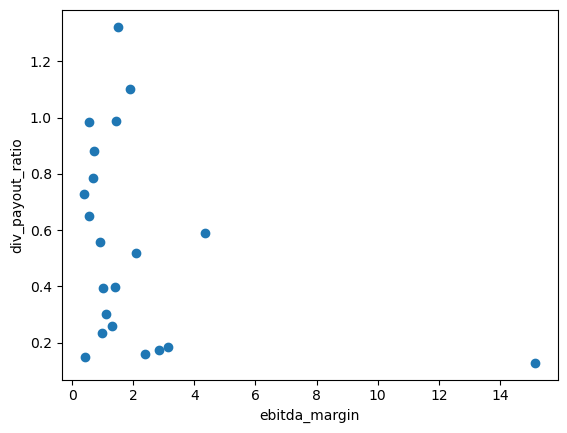

In [72]:
import matplotlib.pyplot as plt

plt.scatter(financials_late['ebitda_margin'], financials_late['div_payout_ratio'])
plt.xlabel('ebitda_margin')
plt.ylabel('div_payout_ratio')
plt.show()